In [29]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
import seaborn as sns

from RegressionFunc import *

In [30]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
%autoreload 2 

### Объединение данных за все года + усреднение до суток

In [32]:
df = pd.read_csv('../data/gfs_days.csv', sep = ';', index_col = 'Date', parse_dates = ['Date'])

# Температурные инверсии
df['DT1'] = df['TMP_mb_1000'] - df['TMP_mb_925']
df['DT2'] = df['TMP_mb_925'] - df['TMP_mb_850']
df['DT3'] = df['TMP_mb_1000'] - df['TMP_mb_850']

In [33]:
X = df.values

### Стандартизация признаков

In [34]:
sc = StandardScaler()
X_std = sc.fit_transform(X)

### Вычисление ковариационной матрицы, а также собственных векторов и собственных значений

In [35]:
cov_mat = np.cov(X_std.T)

In [36]:
eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)

### Кумулятивная сумма объясненных дисперсий

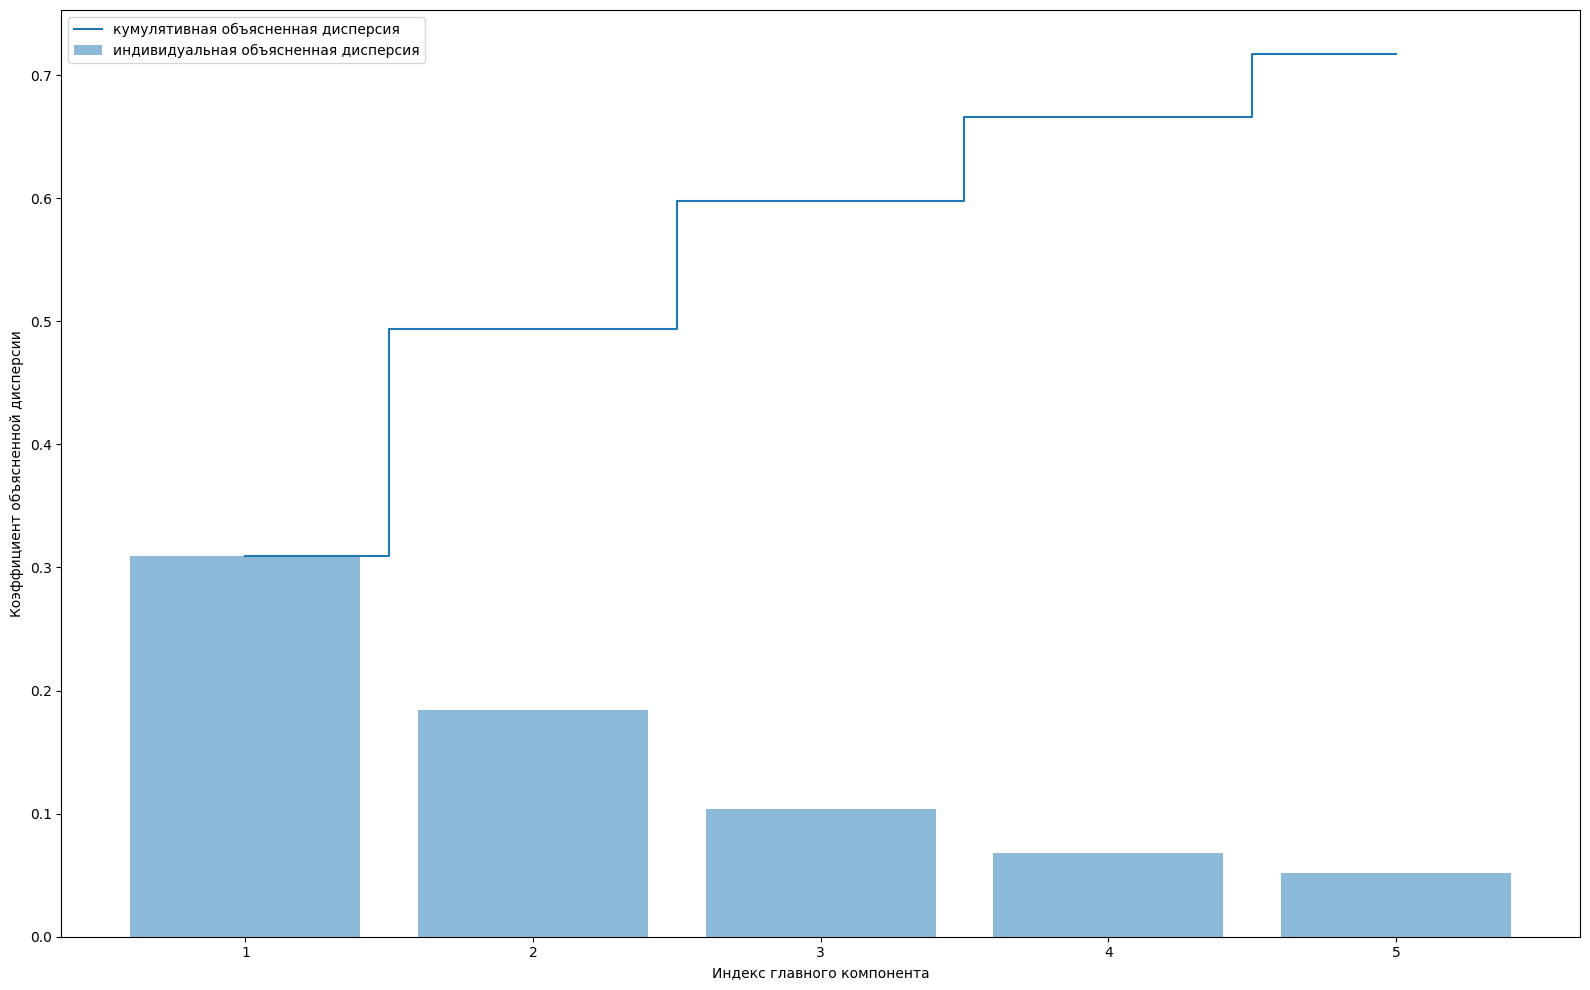

In [37]:
tot = sum(eigen_vals) # Сумма собственных значений
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse = True)] # Доля объяснённой дисперсии
cum_var_exp = np.cumsum(var_exp)
plt.figure(figsize = (16, 10))
plt.bar(range(1,6), var_exp[:5], alpha = 0.5, align = 'center', label = 'индивидуальная объясненная дисперсия')
plt.step(range(1,6), cum_var_exp[:5], where ='mid', label = 'кумулятивная объясненная дисперсия')
plt.ylabel('Коэффициент объясненной дисперсии')
plt.xlabel('Индекс главного компонента')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show() 

In [38]:
# Определение числа главных компонент, объясняющих 80% дисперсии
def countPca(eig_vals):
    s = sum(eig_vals)
    tempS = 0
    k = 1
    for val in sorted(eig_vals, reverse = True):
        tempS += val
        print(f'{k}-я главная компонента объясняет {round(val/s*100, 2)}% дисперсии')
        if tempS / s >= 0.80:
            print(f'Первые {k} главных компонент объясняют {round(tempS / s * 100, 2)}% дисперсии')
            return k
        k += 1

In [39]:
k = countPca(eigen_vals)

1-я главная компонента объясняет 30.92% дисперсии
2-я главная компонента объясняет 18.42% дисперсии
3-я главная компонента объясняет 10.41% дисперсии
4-я главная компонента объясняет 6.82% дисперсии
5-я главная компонента объясняет 5.14% дисперсии
6-я главная компонента объясняет 3.75% дисперсии
7-я главная компонента объясняет 2.64% дисперсии
8-я главная компонента объясняет 2.09% дисперсии
Первые 8 главных компонент объясняют 80.18% дисперсии


### Сортировка собственных пар в порядке убывания собственных значений

In [40]:
# Cоздать список кортежей (собственное значение, собственный вектор)
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
# Oтсортировать кортежи (собственное значение, собственный вектор) от высоких к низким
eigen_pairs.sort(key=lambda k: k[0], reverse = True) 
#eigen_pairs

### Соберем 8 собственных векторов, которые соответствуют 8 наибольшим собственным значениям, чтобы захватить около 80% дисперсии в наборе данных

In [41]:
w = np.hstack([eigen_pairs[i][1] [:, np.newaxis] for i in range(k)])

In [42]:
pd.DataFrame(w)

,0,1,2,3,4,5,6,7
0,-0.110043,0.067084,-0.029403,-0.038398,0.044406,-0.041217,0.029377,-0.100963
1,-0.018467,-0.014092,0.084001,0.039327,0.056104,0.040785,0.209023,-0.046853
2,-0.019121,-0.016579,0.081207,0.040675,0.004580,0.028137,0.252141,-0.036925
3,-0.019026,-0.009759,0.062849,0.033914,-0.036039,0.009176,0.264837,-0.006925
4,-0.001438,0.021104,0.053956,0.027717,-0.067355,0.004537,0.240636,0.045883
...,...,...,...,...,...,...,...,...
157,-0.011111,0.012277,-0.036945,0.014457,0.008790,0.074915,0.000160,0.029437
158,-0.101249,0.043515,-0.028417,0.079855,-0.016954,-0.077721,-0.023513,0.137999
159,0.030158,-0.092251,0.124806,-0.064478,0.077077,0.054158,0.080986,-0.051989
160,0.075421,-0.075846,0.046089,-0.031366,0.125581,0.080979,-0.010939,-0.021223


## Определение весов, с которыми признаки входят в первые 5 главные компоненты

In [43]:
names = pd.read_csv('../data/Names.csv', header = None)
names

,0,1
0,4LFTX,Лучший (4-слойный) индекс поднятия над поверхн...
1,ABSV_mb_700,Абсолютная завихренность на 700mb (1/сек)
2,ABSV_mb_750,Абсолютная завихренность на 750mb (1/сек)
3,ABSV_mb_800,Абсолютная завихренность на 800mb (1/сек)
4,ABSV_mb_850,Абсолютная завихренность на 850mb (1/сек)
...,...,...
171,WEASD,Водный эквивалент накопленной толщины снежного...
172,WILT,Tочка увядания (доля)
173,DT1,Приземные и приподнятые инверсии
174,DT2,Высотные инверсии


In [44]:
descr = []
for col in df.columns:
    if col in names[0].values:
        descr.append(names[names[0]==col][1].values[0])

In [45]:
weights = pd.DataFrame(index = df.columns)
weights['Расшифровка'] = descr
for i in range(5):
    weights[f'{i+1} компонента'] = abs(w[:, i]) # Взятие модуля

In [46]:
weights.sort_values(by='1 компонента', ascending=False).iloc[:, [0, 1]]

,Расшифровка,1 компонента
TMP_mb_900,Температура на 900mb (К),0.131319
TMP_mb_925,Температура на 925mb (К),0.131054
TMP_mb_850,Температура на 850mb (К),0.130819
APTMP,Кажущаяся температура (К),0.130416
TMP_msl_1829,Температура на 1829 м над уровнем моря (К),0.130352
...,...,...
HGT_max_wind,Геопотенциальная высота при макс. ветре (гал/мин),0.003742
ABSV_mb_850,Абсолютная завихренность на 850mb (1/сек),0.001438
VVEL_mb_850,Вертикальная завихренность на 850mb (Па/сек),0.000878
VGRD_mb_850,V-компонента ветра на 850mb (м/с),0.000383


### Трансформируем весь  набор данных в 8 главных компонент, вычислив скалярное произведение матриц X'=XW

In [47]:
X_pca = X_std.dot(w)

In [48]:
pd.DataFrame(X_pca)

,0,1,2,3,4,5,6,7
0,-5.551524,7.275830,0.218497,1.872473,-1.968988,2.418232,-2.402050,1.921479
1,-8.401819,5.933879,1.256248,0.719182,-2.178955,3.192792,-1.792751,2.965775
2,-8.446252,7.046786,0.985680,0.512849,-1.003716,3.173487,0.741020,1.953896
3,-4.938763,9.132810,-5.493341,2.779783,1.248495,0.223895,0.179649,2.095627
4,-9.296922,2.575599,-3.050237,0.188916,0.242126,0.264554,-1.336170,3.008355
...,...,...,...,...,...,...,...,...
1542,-0.479075,4.241107,-7.991991,2.287876,3.063034,-0.389741,0.989008,1.016240
1543,-3.645735,-1.240785,0.210432,0.320994,1.536213,0.099049,0.315983,0.580445
1544,-5.084238,-6.363829,-2.825133,-4.689684,0.002544,-2.189395,1.380261,0.769950
1545,-4.069978,-7.548558,-3.401464,-2.606766,-0.396406,-0.024565,0.502390,2.283263


## Данные PM 2.5

In [49]:
# Среднесуточные данные PM 2.5 Министерство
dfAll = pd.read_csv(f"../data/pm25_m.csv", sep = ';', index_col = ['Date'], parse_dates = ['Date'])

# Размерность массива X меньше размерности значений целевой переменной (до 27 марта 2023), поэтому построим регрессию на меньшей размерности
dfAll = dfAll[:"2023-03-27 12:00:00"] # Срез до конца 2022 года
dfAll.drop(['Березовка', 'Кубеково'], axis = 1, inplace = True)
dfAll

,Черемушки,Кировский,Покровка,Северный,Солнечный,Свердловский,Ветлужанка
Date,,,,,,,
2019-01-01,NaN,NaN,88.40,NaN,NaN,NaN,NaN
2019-01-02,NaN,NaN,33.99,NaN,NaN,NaN,NaN
2019-01-03,NaN,NaN,9.36,NaN,NaN,NaN,NaN
2019-01-04,NaN,NaN,44.34,NaN,NaN,NaN,NaN
2019-01-05,NaN,NaN,62.41,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-03-23,13.41,15.68,11.88,8.86,16.79,14.63,24.77
2023-03-24,20.45,17.77,5.62,11.56,9.07,10.15,9.19
2023-03-25,9.93,8.95,3.74,7.36,7.44,4.85,7.40


In [50]:
# Усреднение данных по всем датчикам
pm = dfAll.mean(axis = 1)
pm

Date
2019-01-01    88.400000
2019-01-02    33.990000
2019-01-03     9.360000
2019-01-04    44.340000
2019-01-05    62.410000
                ...    
2023-03-23    15.145714
2023-03-24    11.972857
2023-03-25     7.095714
2023-03-26     7.052857
2023-03-27     6.695714
Length: 1547, dtype: float64

In [51]:
# Количество пропусков в данных
pm.isnull().sum()

20

In [52]:
# Добавим колонку pm, чтобы затем удалить пропуски во всех данных
X = pd.DataFrame(X_pca)
X.index = pm.index
X['pm'] = pm.values
X

,0,1,2,3,4,5,6,7,pm
Date,,,,,,,,,
2019-01-01,-5.551524,7.275830,0.218497,1.872473,-1.968988,2.418232,-2.402050,1.921479,88.400000
2019-01-02,-8.401819,5.933879,1.256248,0.719182,-2.178955,3.192792,-1.792751,2.965775,33.990000
2019-01-03,-8.446252,7.046786,0.985680,0.512849,-1.003716,3.173487,0.741020,1.953896,9.360000
2019-01-04,-4.938763,9.132810,-5.493341,2.779783,1.248495,0.223895,0.179649,2.095627,44.340000
2019-01-05,-9.296922,2.575599,-3.050237,0.188916,0.242126,0.264554,-1.336170,3.008355,62.410000
...,...,...,...,...,...,...,...,...,...
2023-03-23,-0.479075,4.241107,-7.991991,2.287876,3.063034,-0.389741,0.989008,1.016240,15.145714
2023-03-24,-3.645735,-1.240785,0.210432,0.320994,1.536213,0.099049,0.315983,0.580445,11.972857
2023-03-25,-5.084238,-6.363829,-2.825133,-4.689684,0.002544,-2.189395,1.380261,0.769950,7.095714


In [53]:
# Удаление пропусков
X.dropna(inplace = True)

### Корреляция главных компонент с PM 2.5

# Диаграммы рассеяния

# Линейная регрессия

## Выборки по периодам повышенной концентрации pm 2.5

In [102]:
# Разделение данных по сезонам
def splitDataBySeason(df, season):
    # Зима
    if season == 'winters':
        win19 = df[:'2019-03-01 00:00:00']
        win19_20 = df['2019-11-27 00:00:00':'2020-02-27 00:00:00']
        win20_21 = df['2020-11-27 00:00:00':'2021-02-25 00:00:00']
        win21_22 = df['2021-12-15 00:00:00':'2022-02-22 00:00:00']
        win22_23 = df['2022-12-13 00:00:00' : '2023-02-22 00:00:00']

        return pd.concat([win19, win19_20, win20_21, win21_22, win22_23])
    
    # Весна
    if season == 'springs':
        spr19 = pd.concat([df['2019-03-10' : '2019-05-01'], df['2019-11-01' : '2019-11-22']])
        spr20 = pd.concat([df['2020-03-01' : '2020-05-01'], df['2020-11-01' : '2020-11-10']])
        spr21 = pd.concat([df['2021-03-10' : '2021-05-01'], df['2021-11-01' : '2021-11-25']])
        spr22 = pd.concat([df['2022-03-01' : '2022-05-01'], df['2022-11-01' : '2022-11-25']])
        spr23 = df['2023-03-01' : ]

        return pd.concat([spr19, spr20, spr21, spr22, spr23])

    # Лето
    if season == 'summers':
        sum19 = df['2019-05-01' : '2019-07-12']
        sum20 = df['2020-05-01' : '2020-08-01']
        sum21 = df['2021-05-01' : '2021-08-01']
        sum22 = df['2022-05-01' : '2022-08-01']

        return pd.concat([sum19, sum20, sum21, sum22])
    
    # Осень
    if season == 'autumns':
        aut19 = df['2019-08-21' : '2019-10-16']
        aut20 = df['2020-08-17' : '2020-10-30']
        aut21 = df['2021-08-15' : '2021-11-01']
        aut22 = df['2022-08-01' : '2022-10-14']

        return pd.concat([aut19, aut20, aut21, aut22])

In [103]:
season = 'winters'

fileName = 'XGBoost.xlsx'

# Регрессия на новые признаки (компоненты)

In [104]:
data = splitDataBySeason(X, season)

In [105]:
resultDfs = BuildModels(data, modelType = 'xgbReg')

,Train,CV,Test
"{'learning_rate': 0.1, 'n_estimators': 890}",,,
MSE,16.76,18.14,27.53
MAE,3.04,3.17,3.50
MAPE,0.31,0.32,0.40
R2,0.47,0.42,0.39
R2_adj,0.45,NaN,0.14


### Отбор компонент по корреляции с pm

In [107]:
# Отбор компонент по корреляции с pm
def CompSelect(data, corrPMvalue = 0.2):
    components = []
    for comp, corrVal in data.corr()['pm'].items():
        if abs(corrVal) >= corrPMvalue:
            components.append(comp)
    return components


corrPMvalue = 0.2
components = CompSelect(data, corrPMvalue = corrPMvalue) # pm нужно оставить, т.к. в data должна быть целевая переменная

data = data[components]
data

,0,1,2,pm
Date,,,,
2019-08-21,7.655790,-0.728469,2.335254,8.688000
2019-08-22,10.335574,0.119404,-1.708677,11.036000
2019-08-23,7.192633,-3.320252,2.004169,10.670000
2019-08-24,2.666470,-4.451983,6.581603,5.386000
2019-08-25,4.392048,-4.333913,1.213842,18.430000
...,...,...,...,...
2022-10-10,-1.318573,-7.583848,1.424599,7.943333
2022-10-11,-4.671193,-11.537503,-1.183695,4.451667
2022-10-12,-2.469017,-4.892756,5.364881,4.966000


### Построение моделей

In [108]:
resultDfs = BuildModels(data, modelType = 'xgbReg')

,Train,CV,Test
"{'learning_rate': 0.1, 'n_estimators': 100}",,,
MSE,18.78,19.65,26.93
MAE,3.15,3.23,3.39
MAPE,0.31,0.32,0.39
R2,0.41,0.37,0.40
R2_adj,0.40,NaN,0.33


# Регрессия на признаки по вхождению в главные компоненты

In [110]:
# Веса вхождения признаков в каждую главную компоненту
weights_k = pd.DataFrame(index = df.columns)
for i in range(k):
    weights_k[f'{i+1} компонента'] = abs(w[:, i]) # Взятие модуля
weights_k

,1 компонента,2 компонента,3 компонента,4 компонента,5 компонента,6 компонента,7 компонента,8 компонента
4LFTX,0.110043,0.067084,0.029403,0.038398,0.044406,0.041217,0.029377,0.100963
ABSV_mb_700,0.018467,0.014092,0.084001,0.039327,0.056104,0.040785,0.209023,0.046853
ABSV_mb_750,0.019121,0.016579,0.081207,0.040675,0.004580,0.028137,0.252141,0.036925
ABSV_mb_800,0.019026,0.009759,0.062849,0.033914,0.036039,0.009176,0.264837,0.006925
ABSV_mb_850,0.001438,0.021104,0.053956,0.027717,0.067355,0.004537,0.240636,0.045883
...,...,...,...,...,...,...,...,...
VWSH_tropo,0.011111,0.012277,0.036945,0.014457,0.008790,0.074915,0.000160,0.029437
WEASD,0.101249,0.043515,0.028417,0.079855,0.016954,0.077721,0.023513,0.137999
DT1,0.030158,0.092251,0.124806,0.064478,0.077077,0.054158,0.080986,0.051989
DT2,0.075421,0.075846,0.046089,0.031366,0.125581,0.080979,0.010939,0.021223


## Отбор признаков, коррелирующих с pm по модулю >= 0.2, не коррелирующих между собой (т.е. <= 0.6 по модулю)

In [111]:
data = splitDataBySeason(df, season)

In [112]:
pd.options.mode.chained_assignment = None

### Выбор по nf признаков из k главных компонент

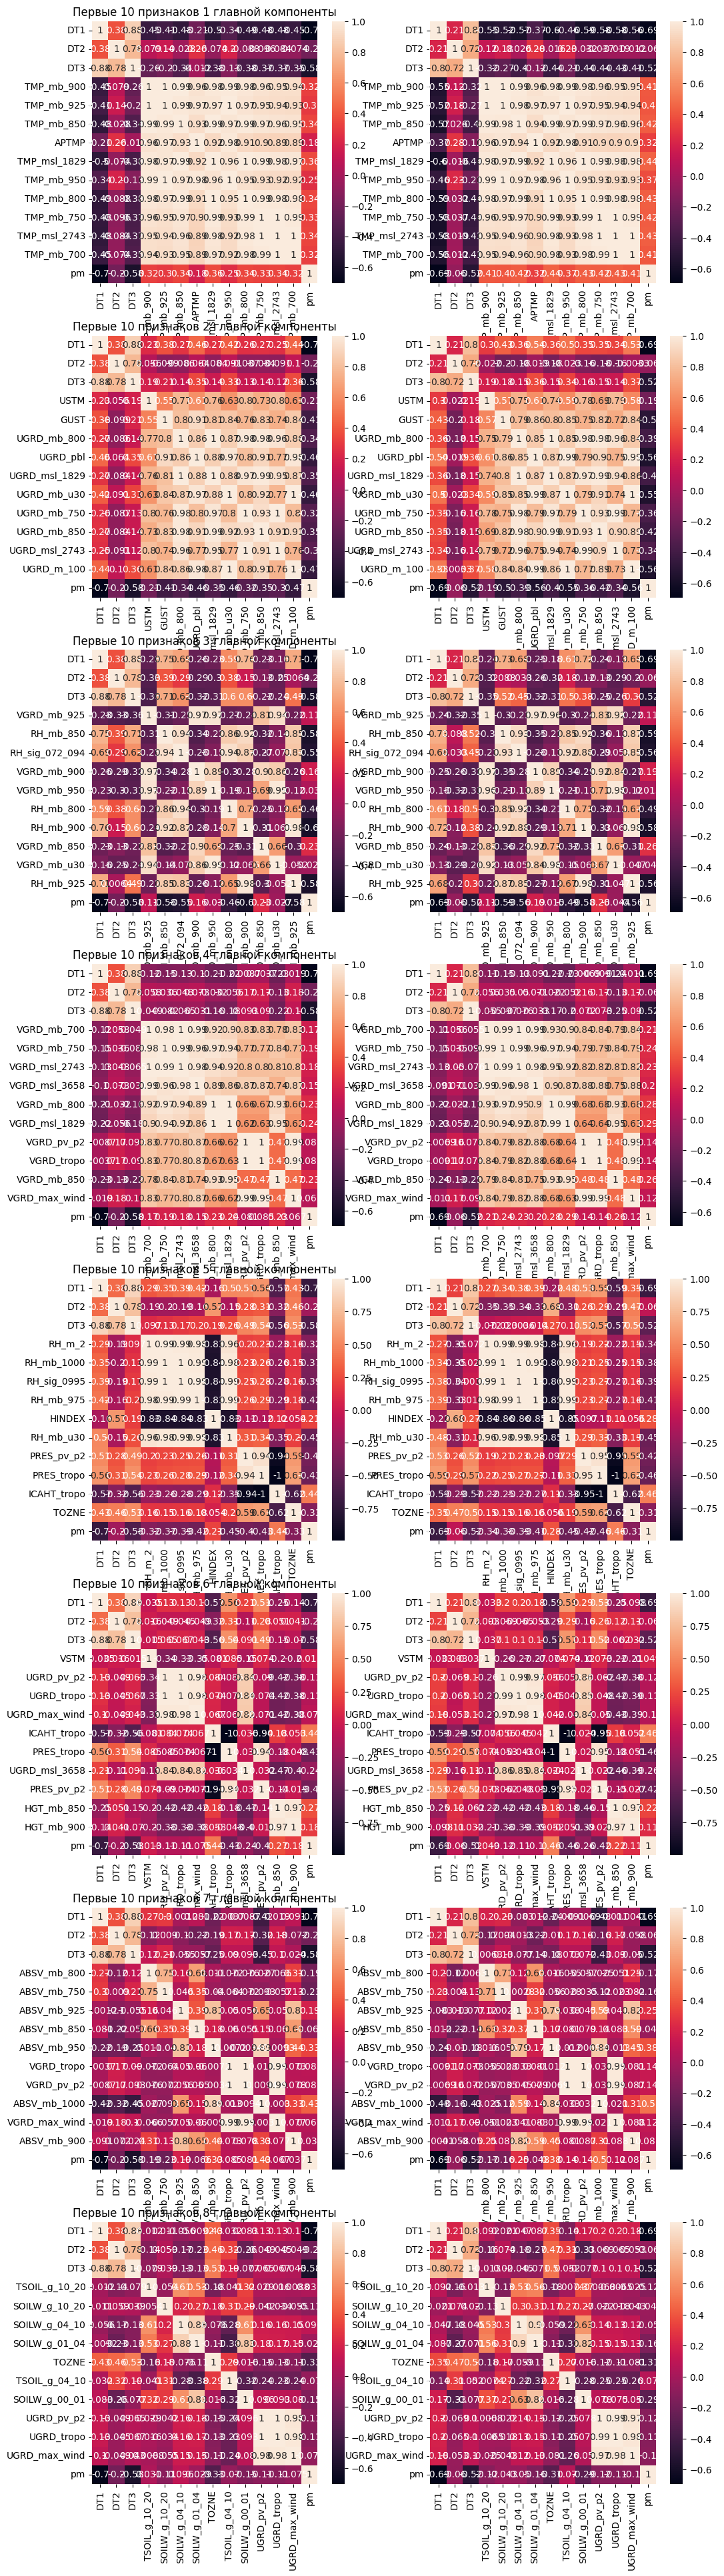

In [113]:
nf = 10 # Количество признаков
k = 8 # количество главных компонент

features = []

plt.figure(figsize = (12, 6*k))
for i in range(k):
    feati = ['DT1', 'DT2', 'DT3'] # Добавление инверсий
    # Признаки i-й главной компоненты 
    for feat in list(weights_k.sort_values(by=f'{i+1} компонента', ascending=False).iloc[:, [0, 1]].index[:nf]):
        feati.append(feat)
        
    tdf = df.loc[data.index][feati]
    tdf['pm'] = pm.loc[data.index]
    
    #sns.heatmap(tdf.corr(), annot = True)
    
    #plt.show()
    
    # Корреляции Пирсона (слева) и Спирмена (справа)
    plt.subplot(k, 2, 2*i+1)
    sns.heatmap(tdf.corr(), annot = True)
    
    plt.title(f'Первые {nf} признаков {i+1} главной компоненты')
    
    plt.subplot(k, 2, 2*i+2)
    spear = tdf.corr(method = 'spearman')
    sns.heatmap(spear, annot = True)
    
    # Отбор признаков
    featureSelect(spear, features)
    
plt.show()

# Заключительный отбор для всех отобранный признаков
tdf = df.loc[data.index][features]
features = []
tdf['pm'] = pm.loc[data.index]
featureSelect(tdf.corr(method = 'spearman'), features)

In [114]:
features

['DT1',
 'UGRD_pbl',
 'PRES_tropo',
 'RH_mb_u30',
 'TMP_msl_1829',
 'VGRD_msl_1829',
 'SOILW_g_00_01',
 'ABSV_mb_925',
 'HGT_mb_850']

### Построение моделей

In [115]:
X_c = data[features]
X_c['pm'] = pm
X_c.dropna(inplace = True)

resultDfs = BuildModels(X_c, modelType = 'xgbReg')

,Train,CV,Test
"{'learning_rate': 0.05, 'n_estimators': 8000}",,,
MSE,14.46,15.70,23.98
MAE,2.76,2.88,3.13
MAPE,0.29,0.30,0.38
R2,0.54,0.50,0.47
R2_adj,0.53,NaN,0.21


### Сохранение в таблицу